# Overview about clustering algorithms

Clustering is a type of unsupervised learning algorithm where we try to group similar items together. In clustering, we do not have a target to predict. We look at the data and try to group similar data points together.

Clustering algorithms are mainly used for exploratory data mining. They help us to identify patterns in the data. Clustering can be used for data analysis, image segmentation, object recognition, etc.

Clustering can be broadly divided into two subgroups:

1. **Hard Clustering**: In hard clustering, each data point either belongs to a cluster completely or not. For example, in the Uber dataset, each location belongs to exactly one cluster.

2. **Soft Clustering**: In soft clustering, instead of putting each data point into a separate cluster, a probability or likelihood of that data point to be in those clusters is assigned. For example, in the Uber dataset, a location can belong to multiple clusters with varying degrees of probability.

There are many clustering algorithms available. Some of the most popular clustering algorithms are (excerpt from scikit-learn):
|Method name|Parameters|Scalability|Use Case|Geometry (metric used)|
|---|---|---|---|---|
|[K-Means](https://scikit-learn.org/stable/modules/clustering.html#k-means)|number of clusters|Very large `n_samples`, medium `n_clusters` with MiniBatch code|General-purpose, even cluster size, flat geometry, not too many clusters|Distances between points|
|[Affinity propagation](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation)|damping, sample preference|Not scalable with `n_samples`|Many clusters, uneven cluster size, non-flat geometry|Graph distance (e.g. nearest-neighbor graph)|
|[Mean-shift](https://scikit-learn.org/stable/modules/clustering.html#mean-shift)|bandwidth|Not scalable with `n_samples`|Many clusters, uneven cluster size, non-flat geometry|Distances between points|
|[Spectral clustering](https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering)|number of clusters|Medium `n_samples`, small `n_clusters`|Few clusters, even cluster size, non-flat geometry|Graph distance (e.g. nearest-neighbor graph)|
|[Ward hierarchical clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)|number of clusters|Large `n_samples` and `n_clusters`|Many clusters, possibly connectivity constraints|Distances between points|
|[Agglomerative clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)|number of clusters, linkage type, distance|Large `n_samples` and `n_clusters`|Many clusters, possibly connectivity constraints, non Euclidean distances|Any pairwise distance|
|[DBSCAN](https://scikit-learn.org/stable/modules/clustering.html#dbscan)|neighborhood size|Very large `n_samples`, medium `n_clusters`|Non-flat geometry, uneven cluster sizes|Distances between nearest points|
|[OPTICS](https://scikit-learn.org/stable/modules/clustering.html#optics)|min sample in neighborhood, max distance|Very large `n_samples`, large `n_clusters`|Non-flat geometry, uneven cluster sizes|Distances between points|
|[Birch](https://scikit-learn.org/stable/modules/clustering.html#birch)|branching factor, threshold, optional global clusterer.|Large `n_clusters` and `n_samples`|Large dataset, outlier removal, data reduction.|Euclidean distance between points|




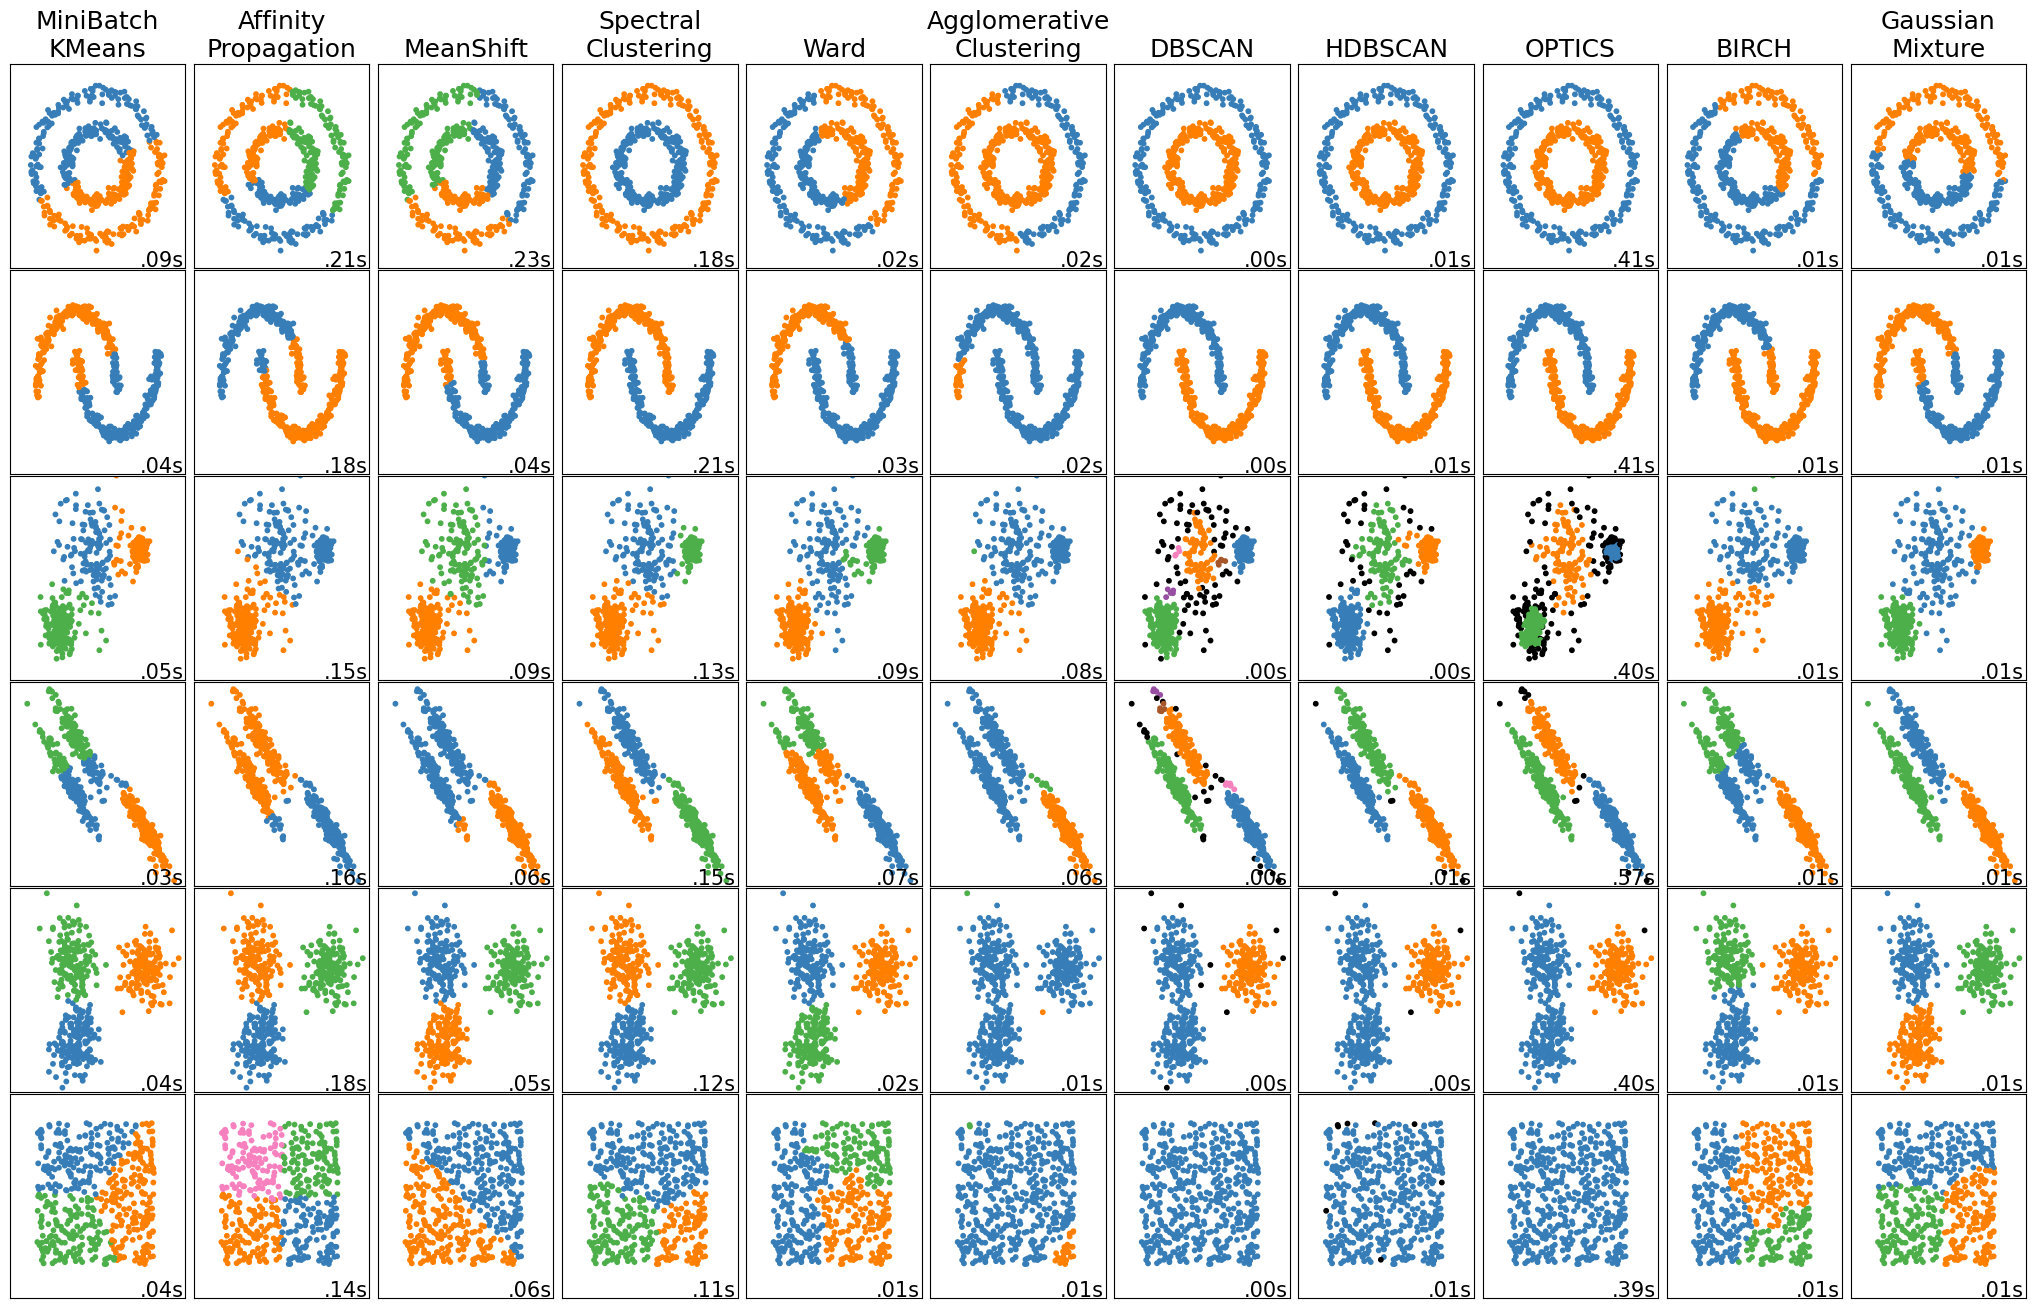

In [6]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

# Steps to perform clustering

### Data Preprocessing 
The first step is to prepare the data for clustering. This step includes cleaning, transforming, and reducing the dimensionality of the data.

### Scatter plot
The second step is to plot the data points on a scatter plot to visualize the data. This step helps us to understand the data distribution and decide the number of clusters.

- Random sampling of the data so that we can plot easily. 
- Or use high performance visualization libraries like NVIDIA Rapids cuXfilter, Datashader, bokeh, etc.

### Choose the right clustering algorithm
The third step is to choose the right clustering algorithm. The choice of the algorithm depends on the data and the problem we are trying to solve. But by looking at the scatter plot and the algorithm comparison, we can get an idea of which algorithm to use.

### Train the model
The fourth step is to train the model on the data. We can use the fit method of the clustering algorithm to train the model.

### Predict the clusters
The fifth step is to predict the clusters for the data points. We can use the predict method of the clustering algorithm to predict the clusters.

### Evaluate the model
The final step is to evaluate the model. We can use different metrics like silhouette score, Davies-Bouldin score, etc., to evaluate the model.


# Example of doing k-means clustering using scikit-learn

In [4]:
# Data loading and preprocessing
import numpy as np
import pandas as pd
# User bokeh for plotting
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.layouts import gridplot
from bokeh.palettes import Spectral11
from bokeh.transform import factor_cmap
from bokeh.models import Legend
from bokeh.models import Range1d
from bokeh.models import LinearAxis
from bokeh.models import DatetimeTickFormatter
output_notebook() # output bokeh plots to notebook


Loading BokehJS ...

In [8]:

# Load data with scikit-learn for k-means clustering
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans


In [33]:

# Create a dataset
X, y = make_blobs(n_samples=1000, centers=5, random_state=42)
df = pd.DataFrame(X, columns=['X1', 'X2'])


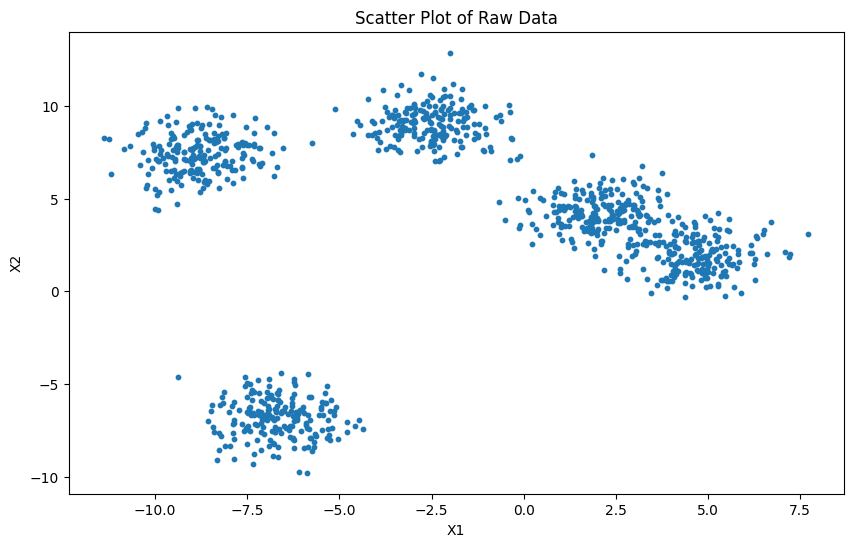

In [36]:
# Plot the data with matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(df['X1'], df['X2'], s=10)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter Plot of Raw Data')
plt.show()



In [14]:
# Cluster the data with k-means
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(df)
df['cluster'] = df['cluster'].astype(str)
df['cluster'] = 'Cluster ' + df['cluster']
df.head()

,X1,X2,cluster
0,5.020077,2.583755,Cluster 4
1,3.232367,1.195353,Cluster 4
2,-6.107928,-9.728652,Cluster 0
3,5.199669,3.053950,Cluster 4
4,1.380819,4.593374,Cluster 1


In [16]:
# Plot clusters with bokeh
source = ColumnDataSource(df)
clusters = df['cluster'].unique().tolist()
palette = Spectral11
color_map = factor_cmap(field_name='cluster', palette=palette, factors=clusters)

p = figure(width=800, height=600, title='K-means clustering', toolbar_location=None)
p.scatter('X1', 'X2', size=10, source=source, legend_field='cluster', fill_color=color_map)
p.xaxis.axis_label = 'X1'
p.yaxis.axis_label = 'X2'
p.legend.title = 'Cluster'
p.legend.location = 'top_left'
p.legend.orientation = 'horizontal'
show(p)


In [18]:
# Do dbscan clustering with scikit-learn and the same data
# The error is intended.
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
df['cluster'] = dbscan.fit_predict(df)
df['cluster'] = df['cluster'].astype(str)
df['cluster'] = 'Cluster ' + df['cluster']
df.head()

ValueError: could not convert string to float: 'Cluster 4'

In [31]:
# Clean up df DBSCAN
# Expected input is a pandas dataframe with columns 'X1' and 'X2' and a column 'cluster' with cluster labels
# Remove "Cluster " from cluster labels
df['cluster'] = df['cluster'].str.replace('Cluster ', '')

In [27]:
df.head()

,X1,X2,cluster
0,5.020077,2.583755,4
1,3.232367,1.195353,4
2,-6.107928,-9.728652,0
3,5.199669,3.053950,4
4,1.380819,4.593374,1


In [34]:
# Do DBSCAN clustering again
dbscan = DBSCAN(eps=1, min_samples=5)
# eps is the maximum distance between two samples for one to be considered as in the neighborhood of the other
# eps with value 0.5 means that two samples are considered neighbors if the distance between the two samples is less than 0.5
# the unit of eps is the same as the unit of the input data.
# min_samples is the number of samples in a neighborhood for a point to be considered as a core point


df['cluster'] = dbscan.fit_predict(df)
df['cluster'] = df['cluster'].astype(str)
df['cluster'] = 'Cluster ' + df['cluster']
df.head()


,X1,X2,cluster
0,5.020077,2.583755,Cluster 0
1,3.232367,1.195353,Cluster 0
2,-6.107928,-9.728652,Cluster 1
3,5.199669,3.053950,Cluster 0
4,1.380819,4.593374,Cluster 0


In [35]:
# Visualize the clusters with bokeh
source = ColumnDataSource(df)
clusters = df['cluster'].unique().tolist()
palette = Spectral11
color_map = factor_cmap(field_name='cluster', palette=palette, factors=clusters)

p = figure(width=800, height=600, title='DBSCAN clustering', toolbar_location=None)
p.scatter('X1', 'X2', size=10, source=source, legend_field='cluster', fill_color=color_map)
p.xaxis.axis_label = 'X1'
p.yaxis.axis_label = 'X2'
p.legend.title = 'Cluster'
p.legend.location = 'top_left'
p.legend.orientation = 'horizontal'
show(p)

# Cluster -1 is the noise/unclassified cluster

# Preprocessing techniques

1. **Standardization**: Standardization is the process of transforming data into a standard scale. Standardization is useful when the features have different ranges. Standardization scales the data to have a mean of 0 and a standard deviation of 1. Standardization is useful when the data has different scales (e.g., age and income). Standardization is useful when the data has outliers, but still follows a normal distribution.

2. **Normalization**: Normalization is the process of scaling the data to a fixed range. Normalization scales the data between 0 and 1.

3. **Dimensionality reduction**: Dimensionality reduction is the process of reducing the number of features in the data. Dimensionality reduction is useful when the data has a large number of features.

4. **Feature selection**: Feature selection is the process of selecting the most important features in the data. Feature selection is useful when the data has a large number of features.

5. **Outlier detection**: Outlier detection is the process of detecting outliers in the data. Depending on the data, outliers can be removed or treated separately. If the goal is to cluster the data, outliers can be removed. If the goal is to detect anomalies, outliers can be treated separately.

6. **Imputation**: Imputation is the process of filling missing values in the data. Missing values can be filled using different techniques like mean, median, mode, etc.

7. **Encoding**: Encoding is the process of converting categorical data into numerical data. Categorical data can be encoded using different techniques like one-hot encoding, label encoding, etc. This is useful when the data has categorical features. Most clustering algorithms work with numerical data, so categorical data needs to be converted into numerical data. However, some clustering algorithms can work with categorical data directly. 

One-hot encoding is a common technique used to convert categorical data into numerical data. But it is useful for machine learning models, not for clustering algorithms. The most common technique used to convert categorical data into numerical data for clustering algorithms is label encoding. 

Label encoding converts each category into a unique number. Label encoding is useful when the categories have an order (ordinal data). If the categories do not have an order (nominal data), clustering is meaningless.


## Standardization example

Formula for standardization:
$$
z = \frac{x - \mu}{\sigma}
$$

where:
- $z$ is the standardized value
- $x$ is the original value
- $\mu$ is the mean of the feature
- $\sigma$ is the standard deviation of the feature



### Key Points:

1. **Preserves Order**: The process of standardization does not alter the order of data points. If one data point is larger than another before standardization, it will remain larger after standardization.

2. **Changes Scale**: While the order is preserved, the scale of the features is changed. This can make the data more suitable for algorithms that are sensitive to the scale of the data, such as K-means clustering, gradient descent-based algorithms, and algorithms that use distance measures like Euclidean distance.

3. **Does Not Reshape**: Standardization does not fundamentally change the shape of the data distribution. If the data is normally distributed before standardization, it will remain normally distributed after. However, the data will now have a mean of 0 and a standard deviation of 1.

4. **Improves Algorithm Performance**: By ensuring that each feature contributes equally to the distance computations, standardization can improve the performance of many machine learning algorithms.

### Example:

Consider a dataset with two features where one feature is measured in centimeters and the other in kilometers. Without standardization, the feature measured in kilometers might dominate distance-based computations due to its larger scale. After standardization, both features will have the same scale, ensuring that no single feature will unduly influence the outcome of algorithms that rely on distance calculations. However, the relative distances between points in each dimension are preserved; what changes is the scale on which these distances are measured.


In [52]:
# Load data with scikit-learn for standardization and k-means clustering
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Create a dataset
X, y = make_blobs(n_samples=1000, centers=5, random_state=42)
df = pd.DataFrame(X, columns=['X1', 'X2'])

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=['X1', 'X2'])

In [44]:
# Function to plot raw data and standardized data side by side
def plot_data(df, df_scaled):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(df['X1'], df['X2'], s=10)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Raw Data')
    plt.subplot(1, 2, 2)
    plt.scatter(df_scaled['X1'], df_scaled['X2'], s=10)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Standardized Data')
    plt.tight_layout()
    plt.show()


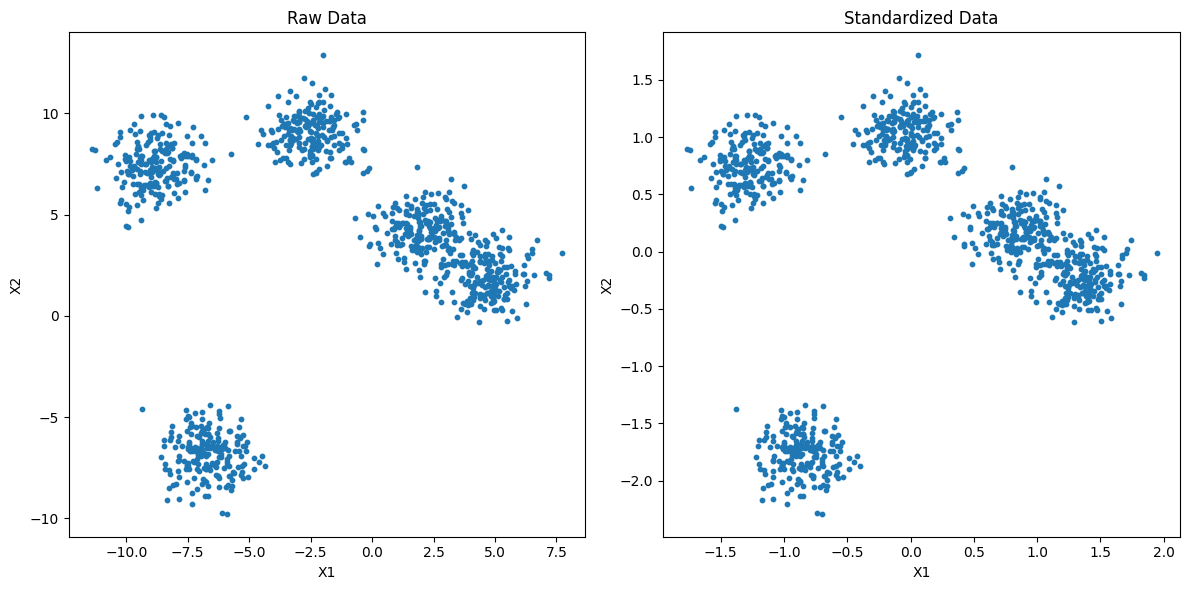

In [53]:
plot_data(df, df_scaled)

In [54]:
# Create data which has different scales to illustrate the effect of standardization
# Create a dataset
import pandas as pd
import numpy as np

# Generate data
np.random.seed(0)
X1 = np.random.randint(1, 11, 100)  # Values from 1 to 10
X2 = np.random.randint(1, 1001, 100)  # Values from 1 to 1000

df = pd.DataFrame({'X1': X1, 'X2': X2})


In [60]:
import numpy as np
import pandas as pd

np.random.seed(42)

# Generate "X1" with small variance
X1 = np.random.normal(50, 1, 200)  # Mean = 50, Std = 1

# Generate "X2" with large variance
X2 = np.random.normal(100, 20, 200)  # Mean = 100, Std = 20

df = pd.DataFrame({'X1': X1, 'X2': X2})

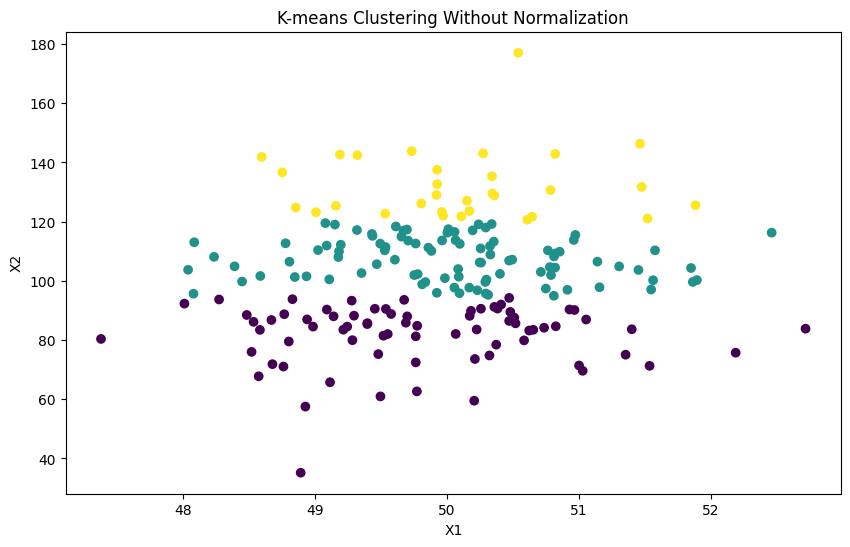

In [61]:
# Apply K-means clustering without standardization

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# K-means clustering without normalization
kmeans = KMeans(n_clusters=3, random_state=42).fit(df)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['X1'], df['X2'], c=kmeans.labels_, cmap='viridis')
plt.title('K-means Clustering Without Normalization')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [62]:
# Normalize the data and apply K-means clustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=['X1', 'X2'])

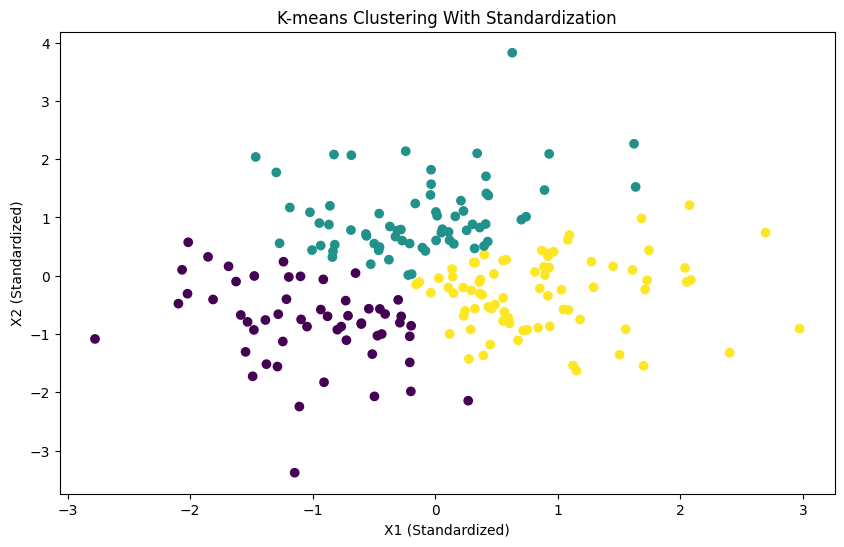

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=['X1', 'X2'])

kmeans_scaled = KMeans(n_clusters=3, random_state=42).fit(df_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(df_scaled['X1'], df_scaled['X2'], c=kmeans_scaled.labels_, cmap='viridis')
plt.title('K-means Clustering With Standardization')
plt.xlabel('X1 (Standardized)')
plt.ylabel('X2 (Standardized)')
plt.show()

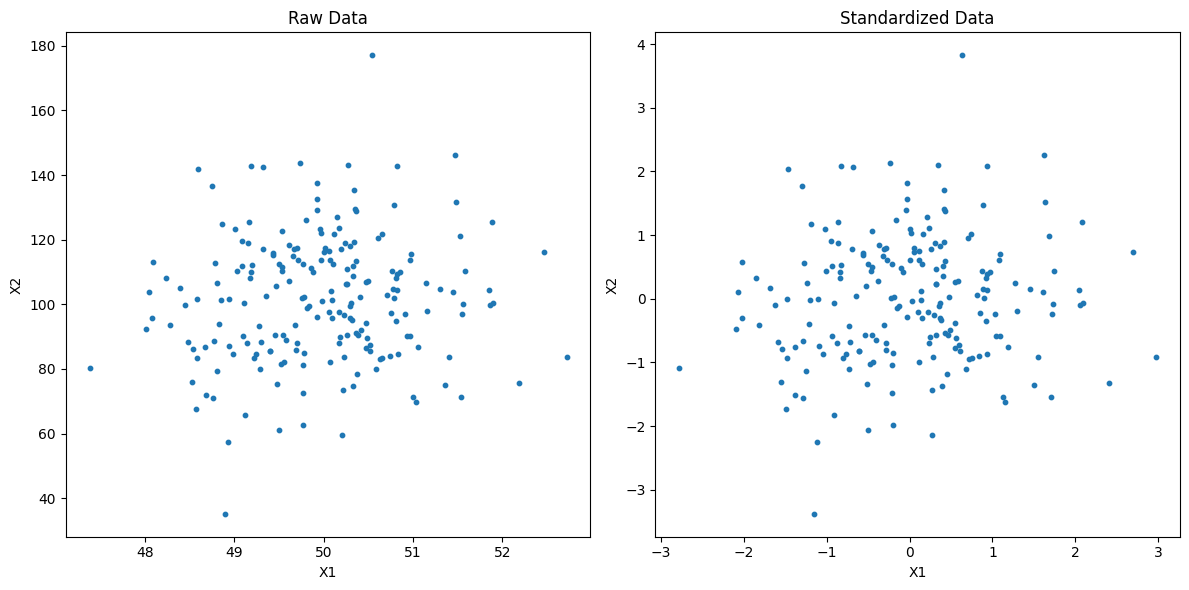

In [63]:
# Plot raw and standardized data side by side
plot_data(df, df_scaled)

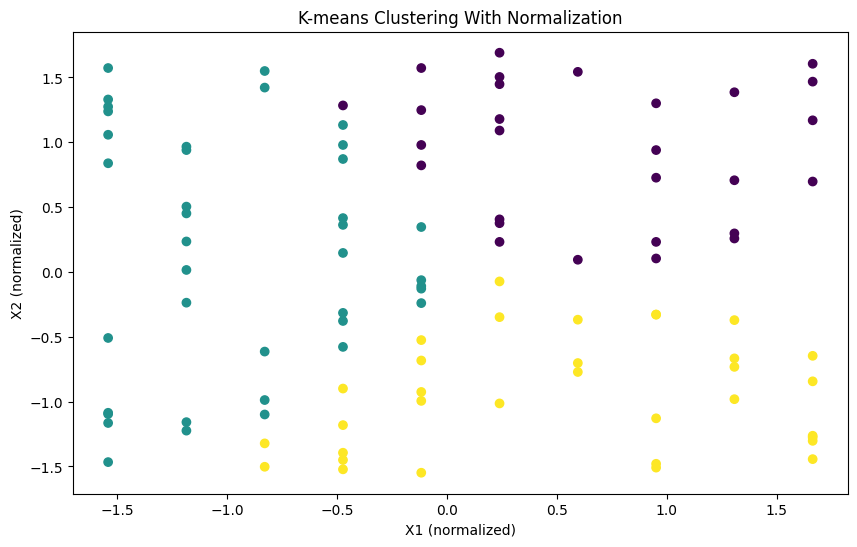

In [59]:
# K-means clustering with normalization
kmeans_scaled = KMeans(n_clusters=3, random_state=42).fit(df_scaled)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_scaled['X1'], df_scaled['X2'], c=kmeans_scaled.labels_, cmap='viridis')
plt.title('K-means Clustering With Normalization')
plt.xlabel('X1 (normalized)')
plt.ylabel('X2 (normalized)')
plt.show()


# Evaluation metrics

1. **Silhouette score**: The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1. A high silhouette score indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

2. **Davies-Bouldin score**: The Davies-Bouldin score is a measure of the average similarity between each cluster and its most similar cluster. The Davies-Bouldin score ranges from 0 to infinity. A lower Davies-Bouldin score indicates better clustering.

3. **Calinski-Harabasz score**: The Calinski-Harabasz score is a measure of the ratio of the sum of between-cluster dispersion to within-cluster dispersion. The Calinski-Harabasz score ranges from 0 to infinity. A higher Calinski-Harabasz score indicates better clustering.

4. **Dunn index**: The Dunn index is a measure of the ratio of the minimum inter-cluster distance to the maximum intra-cluster distance. The Dunn index ranges from 0 to infinity. A higher Dunn index indicates better clustering.

5. **Gap statistic**: The gap statistic is a measure of the difference between the observed and expected dispersion of the data. The gap statistic ranges from -infinity to infinity. A higher gap statistic indicates better clustering.

6. **Elbow method**: The elbow method is a graphical method to determine the optimal number of clusters. The elbow method plots the sum of squared distances between data points and their nearest cluster center against the number of clusters. The optimal number of clusters is the point where the curve starts to flatten out.

7. **Silhouette plot**: The silhouette plot is a graphical method to determine the optimal number of clusters. The silhouette plot plots the silhouette score for each data point against the number of clusters. The optimal number of clusters is the point where the silhouette score is highest.

8. **Davies-Bouldin plot**: The Davies-Bouldin plot is a graphical method to determine the optimal number of clusters. The Davies-Bouldin plot plots the Davies-Bouldin score for each number of clusters. The optimal number of clusters is the point where the Davies-Bouldin score is lowest.




# Distance calculation 

Distance calculation is an important part of clustering algorithms. The distance between data points is used to determine the similarity between data points. The most common distance measure used in clustering algorithms is the Euclidean distance. The Euclidean distance is the straight-line distance between two points in Euclidean space. The Euclidean distance between two points $p$ and $q$ in $n$-dimensional space is given by:

$$
d(p, q) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + \ldots + (p_n - q_n)^2}
$$

where $p = (p_1, p_2, \ldots, p_n)$ and $q = (q_1, q_2, \ldots, q_n)$ are the coordinates of the two points in $n$-dimensional space.

The Euclidean distance is the most common distance measure used in clustering algorithms because it is easy to compute and intuitive. However, other distance measures can also be used in clustering algorithms, depending on the data and the problem we are trying to solve. Some other common distance measures used in clustering algorithms are:

1. **Manhattan distance**: The Manhattan distance is the sum of the absolute differences between the coordinates of two points. The Manhattan distance between two points $p$ and $q$ in $n$-dimensional space is given by:

$$
d(p, q) = |p_1 - q_1| + |p_2 - q_2| + \ldots + |p_n - q_n|
$$

2. **Minkowski distance**: The Minkowski distance is a generalization of the Euclidean distance and the Manhattan distance. The Minkowski distance between two points $p$ and $q$ in $n$-dimensional space is given by:

$$
d(p, q) = \left(\sum_{i=1}^{n} |p_i - q_i|^r\right)^{1/r}
$$

where $r$ is a parameter that determines the type of distance measure. When $r = 1$, the Minkowski distance is the Manhattan distance. When $r = 2$, the Minkowski distance is the Euclidean distance.

3. **Cosine similarity**: The cosine similarity is a measure of the cosine of the angle between two vectors. The cosine similarity between two vectors $p$ and $q$ is given by:

$$
\text{cosine similarity}(p, q) = \frac{p \cdot q}{\|p\| \|q\|}
$$

where $p \cdot q$ is the dot product of the two vectors and $\|p\|$ and $\|q\|$ are the magnitudes of the two vectors.

4. **Jaccard similarity**: The Jaccard similarity is a measure of the intersection over the union of two sets. The Jaccard similarity between two sets $A$ and $B$ is given by:

$$
\text{Jaccard similarity}(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$

where $|A \cap B|$ is the number of elements in the intersection of the two sets and $|A \cup B|$ is the number of elements in the union of the two sets.

5. **Hamming distance**: The Hamming distance is a measure of the number of positions at which the corresponding elements of two strings are different. The Hamming distance between two strings $p$ and $q$ is given by:

$$
d(p, q) = \sum_{i=1}^{n} \delta(p_i, q_i)
$$

where $\delta(p_i, q_i)$ is the Kronecker delta function, which is 0 if $p_i = q_i$ and 1 if $p_i \neq q_i$.

6. **Levenshtein distance**: The Levenshtein distance is a measure of the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one string into another. The Levenshtein distance between two strings $p$ and $q$ is given by:

$$
d(p, q) = \text{minimum number of edits to change } p \text{ into } q
$$

7. **Edit distance**: The edit distance is a measure of the minimum number of operations required to transform one string into another. The edit distance between two strings $p$ and $q$ is given by:

$$
d(p, q) = \text{minimum number of operations to change } p \text{ into } q
$$

